In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["timestamp"])
test = pd.read_csv("data/test.csv", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [3]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [5]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [6]:
train_macro = pd.merge(train, macro, on="timestamp")
test_macro = pd.merge(test, macro, on="timestamp")

In [7]:
train_macro["data"] = "train"
test_macro["data"] = "test"

In [8]:
full_data = train_macro.append(test_macro)

In [9]:
# transform non-numerical variables
for c in full_data.columns:
    if full_data[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(full_data[c].values)) 
        full_data[c] = lbl.transform(list(full_data[c].values))

In [10]:
# seperate full data into train and test again
train_num = full_data[full_data.data == 1]
test_num = full_data[full_data.data == 0]
train_num.set_index("id", inplace=True)
test_num.set_index("id", inplace=True)

In [11]:
# train dataset
y_train = train_num["price_doc"]
x_train = train_num.drop(["timestamp", "price_doc"], axis=1)

# replace missing values with mean values
for c in x_train.columns:
    x_train[c].fillna(x_train[c].mean(), inplace=True)

In [20]:
# test dataset
x_test = test_num.drop(["timestamp", "price_doc"], axis=1)

# replace missing values with mean values
for c in x_test.columns:
    x_test[c].fillna(x_test[c].mean(), inplace=True)
    
# replace missing values with train mean values
for c in x_test.columns:
    x_test[c].fillna(x_train[c].mean(), inplace=True)

In [22]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [23]:
dtrain = xgb.DMatrix(x_train, y_train)

In [24]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.20495e+06	test-rmse:8.21139e+06
[50]	train-rmse:2.52074e+06	test-rmse:2.90294e+06
[100]	train-rmse:2.17403e+06	test-rmse:2.71283e+06
[150]	train-rmse:2.0428e+06	test-rmse:2.6709e+06
[200]	train-rmse:1.9487e+06	test-rmse:2.64668e+06
[250]	train-rmse:1.86923e+06	test-rmse:2.63515e+06
[300]	train-rmse:1.79931e+06	test-rmse:2.62997e+06
[350]	train-rmse:1.7436e+06	test-rmse:2.6244e+06
[400]	train-rmse:1.69042e+06	test-rmse:2.6195e+06
[450]	train-rmse:1.64028e+06	test-rmse:2.61754e+06


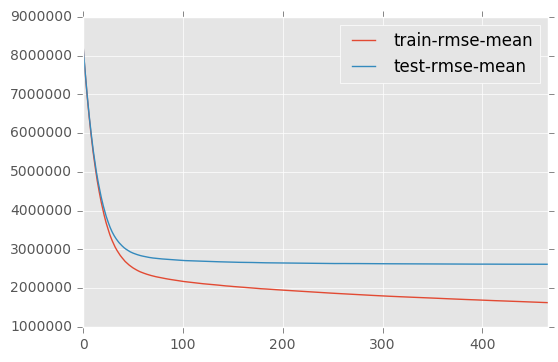

In [25]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [26]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

In [27]:
pred = model.predict(dtrain)

In [28]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [29]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

In [30]:
print("RMSLE: {rmsle}, Error: {error}".format(rmsle=rmsle, error=error))

RMSLE: 12946.935000299547, Error: 36.312105131143866


In [31]:
dtest = xgb.DMatrix(x_test)

In [32]:
y_predict = model.predict(dtest)

In [34]:
output = pd.DataFrame({"id": x_test.index, "price_doc": y_predict})

In [35]:
output.to_csv("submissions_macro.csv", index=False)

# notes
- normalization doesn't work well
- gpd data doesn't help much but makes the model more worse